#In class exercise 1: mapping flights 

Perform some SQL query over the flight dataset and do the following:

* Query the airports present in your country. Plot them
* Query the airlines present in your country. What percentage of them are active?
* Query through routes sourcing from your country. Plot them.
* What about only active airlines? Plot them.
* Which is the most country visited from Spain (not counting Spain)?
* And the least countries visited?

## Query the airports present in your country. Plot them

In [4]:
import sqlite3

def create_connect_database(db_name):
    """Opens connection or creates it if it is not existent"""
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()
    
    return connection, cursor

def commit_close(conn, c, close_connection=True):
    """Commits to connection DB and closes it if close is True"""
    conn.commit()

    if close_connection is True:
        c.close()
        conn.close()
    elif close_connection is False:
        pass

In [2]:
!pip install geopandas

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 14.8MB 295kB/s 
     |████████████████████████████████| 10.9MB 46.0MB/s 


In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Try the SQL query before in DB Browser
connection, cursor = create_connect_database("/content/flights.db")

In [6]:
# Look for examples of plotting airports for countries only above
sql_string_MexAir = "SELECT country,city,CAST(longitude AS float) AS LONG, \
CAST(latitude AS float) AS LAT FROM airports WHERE country='Mexico'; "

airport_locations_Mex = pd.read_sql_query(sql_string_MexAir, connection)
airport_locations_Mex.head()

,country,city,LONG,LAT
0,Mexico,Acapulco,-99.753953,16.757061
1,Mexico,Monterrey,-100.237239,25.865572
2,Mexico,Aguascalientes,-102.317858,21.705558
3,Mexico,Huatulco,-96.262572,15.775317
4,Mexico,Cuernavaca,-99.261300,18.834764


In [7]:
gdf_mex = gpd.GeoDataFrame(airport_locations_Mex, 
                             geometry=gpd.points_from_xy(airport_locations_Mex.LONG, 
                                                               airport_locations_Mex.LAT))
gdf_mex.head()

,country,city,LONG,LAT,geometry
0,Mexico,Acapulco,-99.753953,16.757061,POINT (-99.75395 16.75706)
1,Mexico,Monterrey,-100.237239,25.865572,POINT (-100.23724 25.86557)
2,Mexico,Aguascalientes,-102.317858,21.705558,POINT (-102.31786 21.70556)
3,Mexico,Huatulco,-96.262572,15.775317,POINT (-96.26257 15.77532)
4,Mexico,Cuernavaca,-99.261300,18.834764,POINT (-99.26130 18.83476)


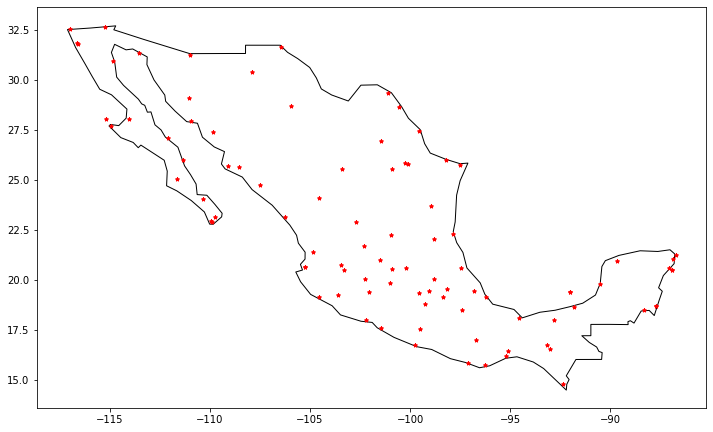

In [8]:
# Retrieve a basemap for the whole world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mex = world.query('name=="Mexico"')
# We plot the whole world.
fig, ax_mex = plt.subplots(1, figsize=(12,13))
ax_mex = mex.plot(ax=ax_mex, color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf_mex.plot(ax=ax_mex, marker='*', color='red', markersize=15)
plt.show()

## Query the airlines present in your country. What percentage of them are active?

In [9]:
# USE WHERE on the SQL call
sql_string_active = "SELECT * \
FROM airlines WHERE country='Mexico' AND active='Y';"

active_airline_Mex = pd.read_sql_query(sql_string_active, connection)
active_airline_Mex.head()

,index,id,name,alias,iata,icao,callsign,country,active
0,164,165,Aerolitoral,\N,5D,SLI,COSTERA,Mexico,Y
1,320,321,AeroMéxico,\N,AM,AMX,AEROMEXICO,Mexico,Y
2,1288,1290,Aeromar,\N,VW,TAO,TRANS-AEROMAR,Mexico,Y
3,1874,1876,Consorcio Aviaxsa,\N,6A,CHP,AVIACSA,Mexico,Y
4,3344,3349,MasAir,\N,M7,MAA,MAS CARGA,Mexico,Y


In [10]:
# Use value counts and normalize
sql_string_active_count = "SELECT Case active \
  WHEN 'Y' then 'Active' \
  ELSE 'Inactive' END AS 'A/I',Count(1) AS Total \
FROM airlines WHERE country='Mexico' \
Group by active;"
active_airline_count = pd.read_sql_query(sql_string_active_count, connection)
active_airline_count.head()
#commit_close(conn=connection, c=cursor, close_connection=True)

,A/I,Total
0,Inactive,427
1,Active,12


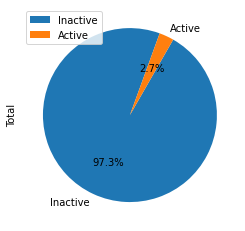

In [11]:
# USE Pie chart
plot = active_airline_count.plot.pie(y='Total',autopct='%1.1f%%',labels=active_airline_count['A/I'],startangle=70)

## Query through routes sourcing from your country. Plot them.

In [13]:
# USE WHERE ON THE SQL CALL
sql_string = "select sou.city AS SourceCity ,sou.country 'SourceCountry', \
CAST(sou.latitude AS float) 'SourceLatitude',CAST(sou.longitude AS float) 'SourceLongitude', \
dest.city 'DestCity',dest.country 'DestCountry', \
CAST(dest.latitude AS float) 'DestLatitude',CAST(dest.longitude AS float) 'DestLongitude' \
from routes r \
inner join airports sou on r.source_id=sou.Id \
inner join airports dest on r.dest_id=dest.Id \
where sou.country='Mexico';"
df = pd.read_sql_query(sql_string, connection)
df.head()

,SourceCity,SourceCountry,SourceLatitude,SourceLongitude,DestCity,DestCountry,DestLatitude,DestLongitude
0,Acapulco,Mexico,16.757061,-99.753953,Mexico City,Mexico,19.436303,-99.072097
1,Acapulco,Mexico,16.757061,-99.753953,Mexico City,Mexico,19.436303,-99.072097
2,Acapulco,Mexico,16.757061,-99.753953,Mexico City,Mexico,19.436303,-99.072097
3,Acapulco,Mexico,16.757061,-99.753953,Monterrey,Mexico,25.778489,-100.106878
4,Acapulco,Mexico,16.757061,-99.753953,Tijuana,Mexico,32.541064,-116.970158


In [15]:
# Retrieve lines using shapely
from shapely.geometry import Point, LineString
point_source = [Point(xy) for xy in zip(df.SourceLongitude, df.SourceLatitude)]
point_dest = [Point(xy) for xy in zip(df.DestLongitude, df.DestLatitude)]

linestring = [LineString(xy) for xy in zip(point_source, point_dest)]

gdf_routes_lines = gpd.GeoDataFrame(df, geometry=linestring)
gdf_routes_lines.head()

,SourceCity,SourceCountry,SourceLatitude,SourceLongitude,DestCity,DestCountry,DestLatitude,DestLongitude,geometry
0,Acapulco,Mexico,16.757061,-99.753953,Mexico City,Mexico,19.436303,-99.072097,"LINESTRING (-99.75395 16.75706, -99.07210 19.4..."
1,Acapulco,Mexico,16.757061,-99.753953,Mexico City,Mexico,19.436303,-99.072097,"LINESTRING (-99.75395 16.75706, -99.07210 19.4..."
2,Acapulco,Mexico,16.757061,-99.753953,Mexico City,Mexico,19.436303,-99.072097,"LINESTRING (-99.75395 16.75706, -99.07210 19.4..."
3,Acapulco,Mexico,16.757061,-99.753953,Monterrey,Mexico,25.778489,-100.106878,"LINESTRING (-99.75395 16.75706, -100.10688 25...."
4,Acapulco,Mexico,16.757061,-99.753953,Tijuana,Mexico,32.541064,-116.970158,"LINESTRING (-99.75395 16.75706, -116.97016 32...."


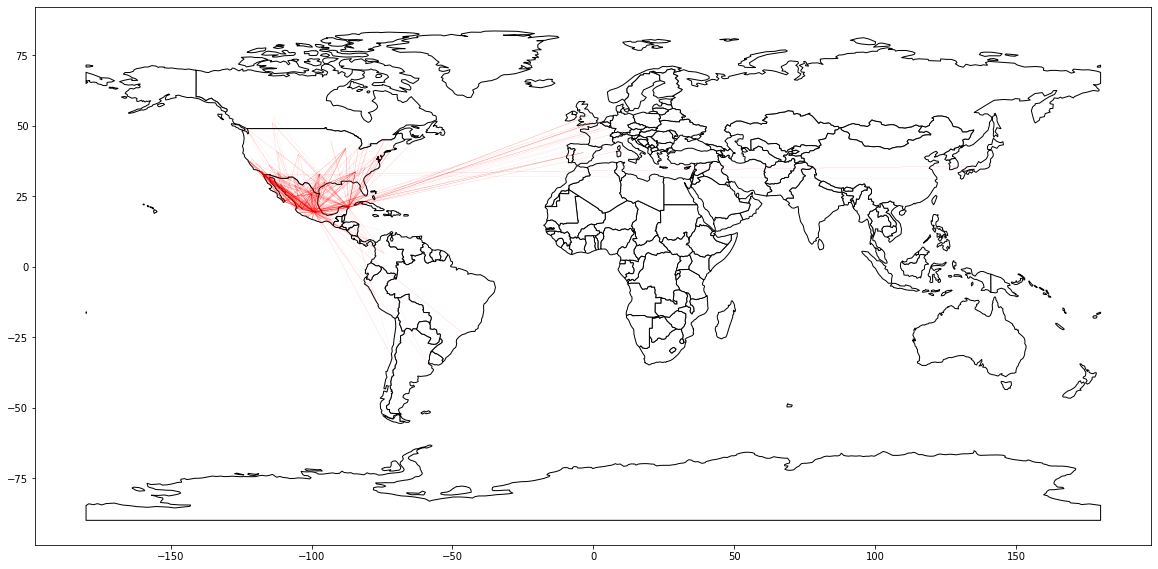

In [16]:
# Plot using geopandas/matplotlib
# Retrieve a basemap for the whole world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# We plot the whole world.
fig, ax = plt.subplots(1, figsize=(20,20))
ax = world.plot(ax=ax, color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf_routes_lines.plot(ax=ax, color='red', linestyle='dotted', linewidth=0.1)
plt.show()

## What about routes sourcing from only active airlines in your country? Plot them.

In [ ]:
# USE WHERE AND AND ON THE SQL QUERY
sql_string = "select a.Active 'AirlineStatus',sou.city AS SourceCity ,sou.country 'SourceCountry', \
CAST(sou.latitude AS float) 'SourceLatitude',CAST(sou.longitude AS float) 'SourceLongitude', \
dest.city 'DestCity',dest.country 'DestCountry', \
CAST(dest.latitude AS float) 'DestLatitude',CAST(dest.longitude AS float) 'DestLongitude' \
from routes r \
inner join airports sou on r.source_id=sou.Id \
inner join airports dest on r.dest_id=dest.Id \
inner join airlines a on r.airline_id=a.Id \
where sou.country='Mexico' AND a.active='Y';"
df = pd.read_sql_query(sql_string, connection)
df.head()

In [ ]:
# Retrieve lines using shapely
from shapely.geometry import Point, LineString
point_source = [Point(xy) for xy in zip(df.SourceLongitude, df.SourceLatitude)]
point_dest = [Point(xy) for xy in zip(df.DestLongitude, df.DestLatitude)]
linestring = [LineString(xy) for xy in zip(point_source, point_dest)]
gdf_routes_lines = gpd.GeoDataFrame(df, geometry=linestring)
gdf_routes_lines.head()

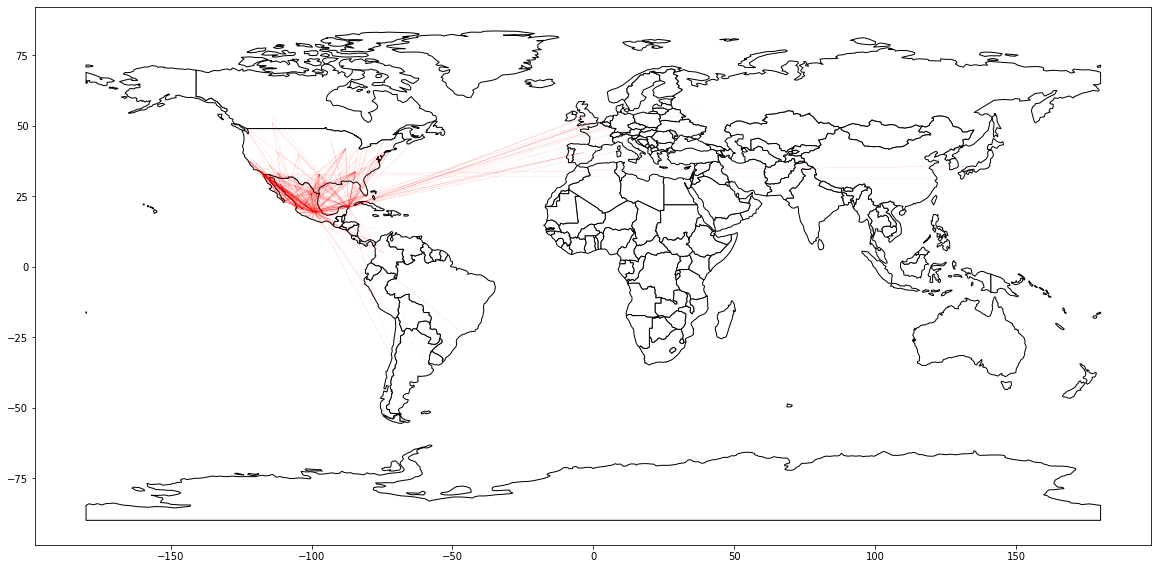

In [21]:
# Plot using geopandas/matplotlib
# Plot using geopandas/matplotlib
# Retrieve a basemap for the whole world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# We plot the whole world.
fig, ax = plt.subplots(1, figsize=(20,20))
ax = world.plot(ax=ax, color='white', edgecolor='black')
# We can now plot our ``GeoDataFrame``.
gdf_routes_lines.plot(ax=ax, color='red', linestyle='dotted', linewidth=0.1)
plt.show()

## Which are the most and least visited countries from Spain?

In [25]:
# Use groupby, count, etc.
sql_string = "select r.dest,dest.country,dest.city, dest.name 'Airport',count(1) 'TotalVisits' \
from routes r \
inner join airlines a on r.airline_id=a.Id \
inner join airports dest on r.dest_id=dest.Id \
where dest.country='Spain' \
group by r.dest,dest.country,dest.city, dest.name;"
df = pd.read_sql_query(sql_string, connection)

df.sort_values(by=['TotalVisits'],ascending=False).head()#Most Visited

,dest,country,city,Airport,TotalVisits
3,BCN,Spain,Barcelona,Barcelona,391
17,MAD,Spain,Madrid,Barajas,329
22,PMI,Spain,Palma de Mallorca,Son Sant Joan,277
1,AGP,Spain,Malaga,Malaga,204
33,TFS,Spain,Tenerife,Tenerife Sur,159


In [24]:
df.loc[df['TotalVisits'] == 1]#Least Visited

,dest,country,city,Airport,TotalVisits
8,GMZ,Spain,La Gomera,La Gomera Airport,1
12,ILD,Spain,Lleida,Lleida-Alguaire Airport,1
15,LEN,Spain,Leon,Leon Airport,1
23,PNA,Spain,Pamplona,Pamplona,1
25,RGS,Spain,Burgos,Burgos Airport,1
26,RJL,Spain,Logroño-Agoncillo,Logroño-Agoncillo Airport,1
29,SLM,Spain,Salamanca,Salamanca,1
